In [1]:
import numpy as np
from pathlib import Path
from utils import MyWarp, annotate
import my_utils as mylib

ROOT = Path("./data")
IMAGES = ROOT / "q1"

AFFINE_ANNOTATION = ROOT / "annotation" / "q1_annotation.npy"
METRIC_ANNOTATION = ROOT / "annotation" / "q2_annotation.npy"

CURRENT_IMAGE = IMAGES / "tiles5.JPG"

In [2]:
data = np.load(AFFINE_ANNOTATION, allow_pickle=True)
affine_annotations = data.item()[CURRENT_IMAGE.stem]

data = np.load(METRIC_ANNOTATION, allow_pickle=True)
metric_annotations = data.item()[CURRENT_IMAGE.stem]

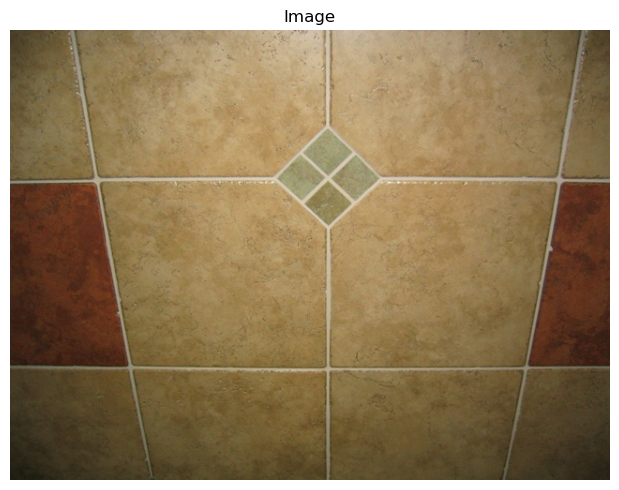

In [3]:
image = mylib.load_image(CURRENT_IMAGE)
mylib.show_images([image], ['Image'])

In [4]:
clicks = annotate(CURRENT_IMAGE)
clicks = np.array(clicks)[:, :2]
metric_annotations = np.vstack((metric_annotations, clicks))
print(metric_annotations.shape)

Collected 5 points
(21, 2)


In [5]:
metric_annotations.shape

(21, 2)

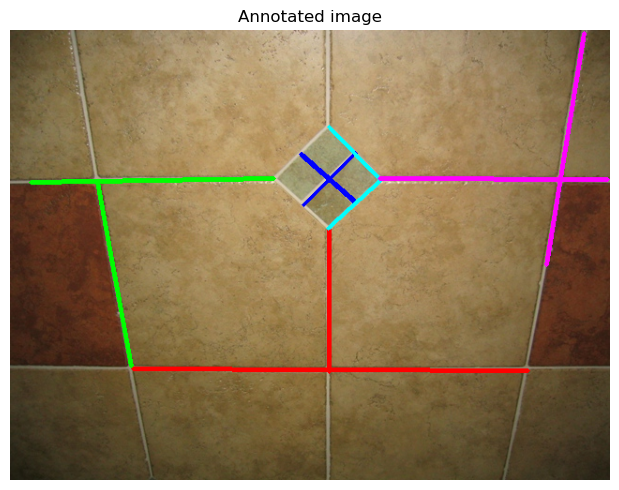

In [6]:
mylib.show_annotated_lines(image, metric_annotations, num_pairs=5)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


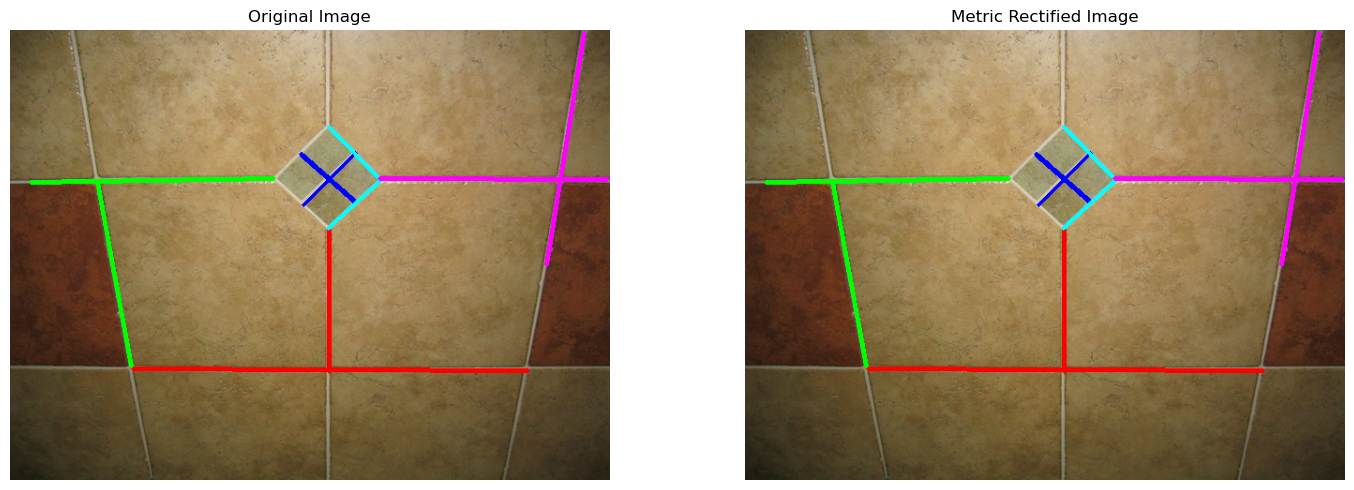

In [7]:
H_metric = mylib.get_metric_rectification_matrix_with_affine_distortion(metric_annotations)
metric_rectified_image = MyWarp(image, H_metric)
print(H_metric)

mylib.show_images([image, metric_rectified_image], ['Original Image', 'Metric Rectified Image'])

In [8]:
mylib.verfiy_angles(H_metric, metric_annotations, num_pairs=5)

Pairs number 1.0:
Before: 0.004750540219098102
After: 0.004750540219098102
Pairs number 2.0:
Before: -0.06293803653600322
After: -0.06293803653600322
Pairs number 3.0:
Before: 0.16771815487166333
After: 0.16771815487166333
Pairs number 4.0:
Before: 0.03498266075814055
After: 0.03498266075814055
Pairs number 5.0:
Before: -0.15798703973124323
After: -0.15798703973124323


In [9]:
from utils import normalize
def to_homo(p):
    return np.array([p[0], p[1], 1])
    
# Add this before the function to test your annotations
def test_orthogonality_quality(annotations, num_pairs=5):
    points = [to_homo(annotations[i]) for i in range(num_pairs * 4)] 
    lines = [normalize(np.cross(points[i], points[i + 1])) for i in range(0, num_pairs * 4, 2)]
    def orthogonality_constraint(l, m):
        l1, l2, l3 = l
        m1, m2, m3 = m
        return np.array([
            l1*m1,
            l1*m2 + l2*m1,
            l2*m2,
            l1*m3 + l3*m1,
            l2*m3 + l3*m2,
            l3*m3
        ], dtype=float)

    print("Input line pair angles (dot products):")
    for i in range(0, len(lines), 2):
        dot = np.dot(lines[i][:2], lines[i+1][:2])  # Check in affine part
        print(f"Pair {i//2 + 1}: {dot:.4f}")
    
    # Check rank of A
    A = np.vstack([
        orthogonality_constraint(lines[i], lines[i + 1]) 
        for i in range(0, len(lines), 2)
    ])
    rank = np.linalg.matrix_rank(A)
    print(f"\nMatrix A rank: {rank} (should be 5 for unique solution)")
    print(f"Matrix A shape: {A.shape}")
    
    # Check singular values
    s = np.linalg.svd(A, compute_uv=False)
    print(f"Singular values: {s}")

test_orthogonality_quality(metric_annotations, num_pairs=5)

Input line pair angles (dot products):
Pair 1: 0.0000
Pair 2: -0.0000
Pair 3: 0.0000
Pair 4: 0.0000
Pair 5: -0.0000

Matrix A rank: 5 (should be 5 for unique solution)
Matrix A shape: (5, 6)
Singular values: [2.23601252e+00 1.16976269e-02 8.77086966e-03 7.63555026e-06
 2.16103653e-07]
